In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

In [2]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        e2 = self.bn2(self.conv2(bn1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
        e5 = self.bn5(self.conv5(e2))
        e6 = self.conv6(e5)

        return e6

In [3]:
class AppliancesCNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomCNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [15]:
torch.manual_seed(0)
num_folds = 5
dataset = 1
fold_num = 0
lr = 0.01
train, test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)

In [16]:
valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

In [59]:
ORDER = ['hvac', 'fridge', 'dr', 'dw', 'mw']
ORDER = ['fridge', 'hvac', 'dr', 'dw', 'mw']
ORDER = ['dw', 'mw', 'fridge', 'hvac', 'dr']
cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

In [60]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_valid = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_valid[a_num] = Variable(
        torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
    if cuda_av:
        out_valid[a_num] = out_valid[a_num].cuda()
        
out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test.shape[0], 1, -1, 24))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

In [61]:
loss_func = nn.L1Loss()
model = AppliancesCNN(len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()

In [62]:
inp = Variable(torch.Tensor(train_aggregate).type(torch.FloatTensor),
               requires_grad=True)

inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()

valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
if cuda_av:
    valid_inp = valid_inp.cuda()

test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

valid_pred = {}
train_pred = {}
test_pred = {}
test_losses = {}
valid_losses = {}

In [63]:
valid_aggregate.shape

(11, 1, 112, 24)

In [64]:
valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

In [ ]:
p = 0
num_iterations = 20000
params = [inp, p]
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])
        
for t in range(1, num_iterations+1):
  
    if cuda_av:
        train_out = train_out.cuda()

    
    pred = model(*params)

    optimizer.zero_grad()
    loss = loss_func(pred, train_out)
    if t % 500 == 0:

        if cuda_av:
            valid_inp = valid_inp.cuda()
        valid_params = [valid_inp, -2]
        for i in range(len(ORDER)):
            valid_params.append(None)
        valid_pr = model(*valid_params)
        valid_loss = loss_func(valid_pr, valid_out)

        if cuda_av:
            test_inp = test_inp.cuda()
        test_params = [test_inp, -2]
        for i in range(len(ORDER)):
            test_params.append(None)
        test_pr = model(*test_params)
        test_loss = loss_func(test_pr, test_out)

        test_losses[t] = test_loss.data[0]
        valid_losses[t] = valid_loss.data[0]
        # np.save("./baseline/p_50_loss")

        if t % 1000 == 0:
            valid_pr = torch.clamp(valid_pr, min=0.)
            valid_pred[t] = valid_pr
            test_pr = torch.clamp(test_pr, min=0.)
            test_pred[t] = test_pr
            train_pr = pred
            train_pr = torch.clamp(train_pr, min=0.)
            train_pred[t] = train_pr

        print("Round:", t, "Training Error:", loss.data[0], "Validation Error:", valid_loss.data[0], "Test Error:", test_loss.data[0])

    loss.backward()
    optimizer.step()



Round: 500 Training Error: 67.36023712158203 Validation Error: 101.37979888916016 Test Error: 79.24258422851562
Round: 1000 Training Error: 48.506465911865234 Validation Error: 90.74720764160156 Test Error: 81.68138885498047
Round: 1500 Training Error: 41.975460052490234 Validation Error: 89.37362670898438 Test Error: 91.28257751464844
Round: 2000 Training Error: 41.4940071105957 Validation Error: 88.96916198730469 Test Error: 89.79879760742188
Round: 2500 Training Error: 40.60870361328125 Validation Error: 89.5868911743164 Test Error: 91.08229064941406
Round: 3000 Training Error: 40.07412338256836 Validation Error: 87.16902923583984 Test Error: 88.00807189941406
Round: 3500 Training Error: 39.065521240234375 Validation Error: 90.32083892822266 Test Error: 90.55892944335938
Round: 4000 Training Error: 39.614227294921875 Validation Error: 89.43894958496094 Test Error: 89.50813293457031
Round: 4500 Training Error: 39.91252136230469 Validation Error: 90.61051940917969 Test Error: 91.07877

In [24]:
from sklearn.metrics import mean_absolute_error

train_fold = [None for x in range(len(ORDER))]

valid_fold = {}
for t in range(1000, num_iterations + 1, 1000):

    valid_pred[t] = torch.split(valid_pred[t], valid_aggregate.shape[0])
    valid_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].data.numpy().reshape(-1, 24)

test_fold = {}
for t in range(1000, num_iterations + 1, 1000):

    test_pred[t] = torch.split(test_pred[t], test_aggregate.shape[0])
    test_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].data.numpy().reshape(-1, 24)

# store ground truth of validation set
valid_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    valid_gt_fold[appliance_num] = valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        valid_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

# calcualte the error of validation set
valid_error = {}
for t in range(1000, num_iterations + 1, 1000):
    valid_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        valid_error[t][appliance] = mean_absolute_error(valid_fold[t][appliance_num], valid_gt_fold[appliance_num])

test_error = {}
for t in range(1000, num_iterations + 1, 1000):
    test_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        test_error[t][appliance] = mean_absolute_error(test_fold[t][appliance_num], test_gt_fold[appliance_num])

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [44]:
test_aggregate.shape

(14, 1, 112, 24)

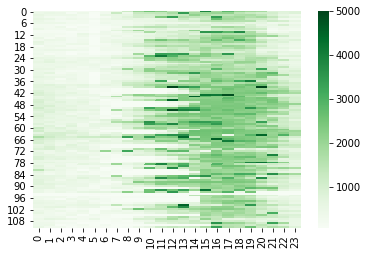

In [45]:
sns.heatmap(pd.DataFrame(test_aggregate[0][0]), cmap='Greens')

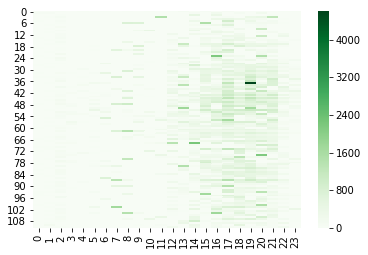

In [58]:
sns.heatmap(pd.DataFrame(test_fold[20000][2].reshape(-1, 112, 24)[10]), cmap='Greens')

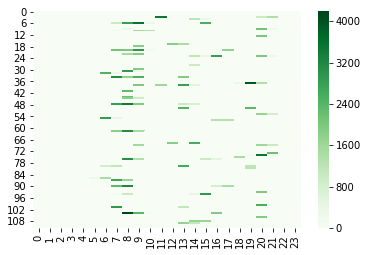

In [57]:
sns.heatmap(pd.DataFrame(test_gt_fold[2].reshape(-1, 112, 24)[10]), cmap='Greens')

In [25]:
test_error

{1000: {'dr': 103.05109335308289,
  'dw': 11.025081509308853,
  'fridge': 29.413692293765674,
  'hvac': 167.42309408342922,
  'mw': 7.6379931115323183},
 2000: {'dr': 125.21000955134691,
  'dw': 11.024307778145825,
  'fridge': 29.042041853108472,
  'hvac': 185.40137434938651,
  'mw': 7.2122579443572974},
 3000: {'dr': 130.39909943155246,
  'dw': 11.024307778145825,
  'fridge': 31.051492384673121,
  'hvac': 186.54717256925269,
  'mw': 7.2014793461672939},
 4000: {'dr': 130.22088564787916,
  'dw': 11.024352028374793,
  'fridge': 31.108969738530543,
  'hvac': 183.84720348463475,
  'mw': 7.1766213004177972},
 5000: {'dr': 129.1211544492933,
  'dw': 11.024586555323287,
  'fridge': 31.283911292864286,
  'hvac': 182.78496545885301,
  'mw': 7.2458296424679958},
 6000: {'dr': 130.3828524357416,
  'dw': 11.02430868254145,
  'fridge': 31.572062828450751,
  'hvac': 180.57148349186977,
  'mw': 7.3255250871153379},
 7000: {'dr': 132.0341465098472,
  'dw': 11.024821942437585,
  'fridge': 31.655822664

In [14]:
test_error

{1000: {'dr': 104.51486100150184,
  'dw': 11.024693286003417,
  'fridge': 43.628079512353146,
  'hvac': 170.66594519918587,
  'mw': 7.1834119964077372},
 2000: {'dr': 132.7653845653841,
  'dw': 11.024307860026147,
  'fridge': 47.901991705041326,
  'hvac': 181.09079424734418,
  'mw': 7.1065447021710924},
 3000: {'dr': 139.08151216003162,
  'dw': 11.024774495282799,
  'fridge': 47.871046935981276,
  'hvac': 183.52738505555899,
  'mw': 7.2129953022498627},
 4000: {'dr': 143.52523411012223,
  'dw': 11.024311092145034,
  'fridge': 47.957222381518989,
  'hvac': 183.53725180561787,
  'mw': 7.3162178633638364},
 5000: {'dr': 147.3578787644916,
  'dw': 11.024311247478749,
  'fridge': 46.48262682793203,
  'hvac': 182.57096604425192,
  'mw': 7.3999224717760086},
 6000: {'dr': 149.68912326295776,
  'dw': 11.024307778145825,
  'fridge': 47.255146366351035,
  'hvac': 181.87193982892714,
  'mw': 7.3724442526361926},
 7000: {'dr': 151.1437072533798,
  'dw': 11.024307853860456,
  'fridge': 46.717229327